In [1]:
%matplotlib inline


# Time-frequency on simulated data (Multitaper vs. Morlet vs. Stockwell)

This example demonstrates the different time-frequency estimation methods
on simulated data. It shows the time-frequency resolution trade-off
and the problem of estimation variance. In addition it highlights
alternative functions for generating TFRs without averaging across
trials, or by operating on numpy arrays.


In [2]:
# Authors: Hari Bharadwaj <hari@nmr.mgh.harvard.edu>
#          Denis Engemann <denis.engemann@gmail.com>
#          Chris Holdgraf <choldgraf@berkeley.edu>
#
# License: BSD (3-clause)

import numpy as np
from matplotlib import pyplot as plt

from mne import create_info, EpochsArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet,
                                tfr_array_morlet)
from mne.viz import centers_to_edges

## Simulate data

We'll simulate data with a known spectro-temporal structure.



Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Need more than one channel to make topography for grad. Disabling interactivity.


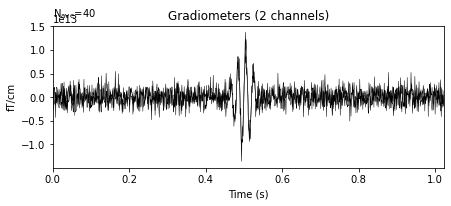

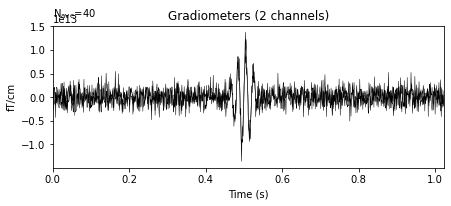

In [3]:
sfreq = 1000.0
ch_names = ['SIM0001', 'SIM0002']
ch_types = ['grad', 'grad']
info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

n_times = 1024  # Just over 1 second epochs
n_epochs = 40
seed = 42
rng = np.random.RandomState(seed)
noise = rng.randn(n_epochs, len(ch_names), n_times)

# Add a 50 Hz sinusoidal burst to the noise and ramp it.
t = np.arange(n_times, dtype=np.float64) / sfreq
signal = np.sin(np.pi * 2. * 50. * t)  # 50 Hz sinusoid signal
signal[np.logical_or(t < 0.45, t > 0.55)] = 0.  # Hard windowing
on_time = np.logical_and(t >= 0.45, t <= 0.55)
signal[on_time] *= np.hanning(on_time.sum())  # Ramping
data = noise + signal

reject = dict(grad=4000)
events = np.empty((n_epochs, 3), dtype=int)
first_event_sample = 100
event_id = dict(sin50hz=1)
for k in range(n_epochs):
    events[k, :] = first_event_sample + k * n_times, 0, event_id['sin50hz']

epochs = EpochsArray(data=data, info=info, events=events, event_id=event_id,
                     reject=reject)

epochs.average().plot()

## Calculate a time-frequency representation (TFR)

Below we'll demonstrate the output of several TFR functions in MNE:

* `mne.time_frequency.tfr_multitaper`
* `mne.time_frequency.tfr_stockwell`
* `mne.time_frequency.tfr_morlet`

### Multitaper transform
First we'll use the multitaper method for calculating the TFR.
This creates several orthogonal tapering windows in the TFR estimation,
which reduces variance. We'll also show some of the parameters that can be
tweaked (e.g., ``time_bandwidth``) that will result in different multitaper
properties, and thus a different TFR. You can trade time resolution or
frequency resolution or both in order to get a reduction in variance.



In [4]:
freqs = np.arange(5., 100., 3.)
vmin, vmax = -3., 3.  # Define our color limits.

# **( Least smoothing (most variance/background fluctuations)**



Applying baseline correction (mode: mean)


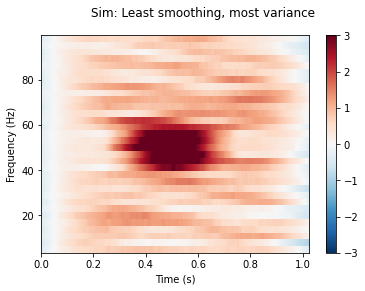

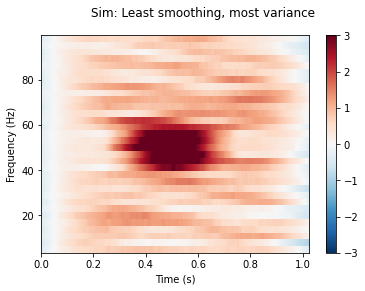

In [5]:
n_cycles = freqs / 2.
time_bandwidth = 2.0  # Least possible frequency-smoothing (1 taper)
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
# Plot results. Baseline correct based on first 100 ms.
power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
           title='Sim: Least smoothing, most variance')

**(2) Less frequency smoothing, more time smoothing.**



Applying baseline correction (mode: mean)


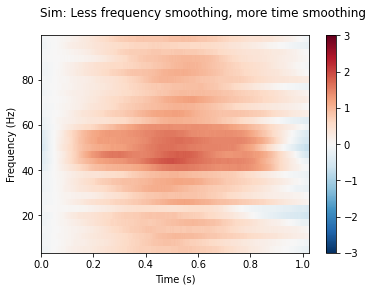

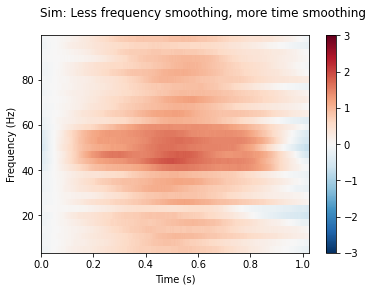

In [6]:
n_cycles = freqs  # Increase time-window length to 1 second.
time_bandwidth = 4.0  # Same frequency-smoothing as (1) 3 tapers.
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
# Plot results. Baseline correct based on first 100 ms.
power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
           title='Sim: Less frequency smoothing, more time smoothing')

**(3) Less time smoothing, more frequency smoothing.**



Applying baseline correction (mode: mean)


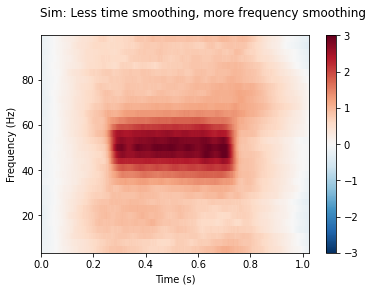

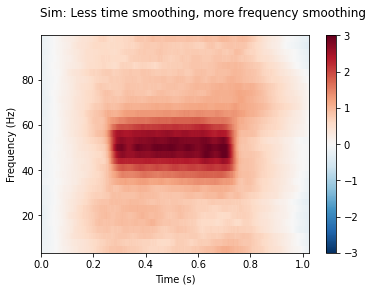

In [7]:
n_cycles = freqs / 2.
time_bandwidth = 8.0  # Same time-smoothing as (1), 7 tapers.
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
# Plot results. Baseline correct based on first 100 ms.
power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
           title='Sim: Less time smoothing, more frequency smoothing')

### Stockwell (S) transform

Stockwell uses a Gaussian window to balance temporal and spectral resolution.
Importantly, frequency bands are phase-normalized, hence strictly comparable
with regard to timing, and, the input signal can be recoverd from the
transform in a lossless way if we disregard numerical errors. In this case,
we control the spectral / temporal resolution by specifying different widths
of the gaussian window using the ``width`` parameter.



Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


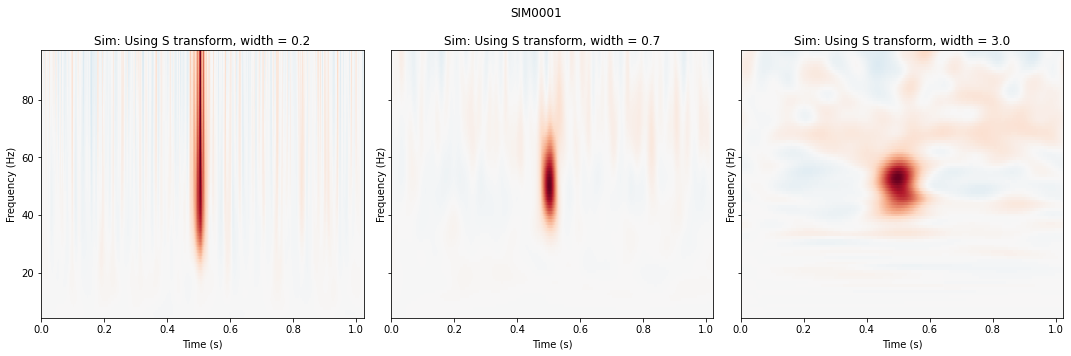

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fmin, fmax = freqs[[0, -1]]
for width, ax in zip((0.2, .7, 3.0), axs):
    power = tfr_stockwell(epochs, fmin=fmin, fmax=fmax, width=width)
    power.plot([0], baseline=(0., 0.1), mode='mean', axes=ax, show=False,
               colorbar=False)
    ax.set_title('Sim: Using S transform, width = {:0.1f}'.format(width))
plt.tight_layout()

### Morlet Wavelets

Finally, show the TFR using morlet wavelets, which are a sinusoidal wave
with a gaussian envelope. We can control the balance between spectral and
temporal resolution with the ``n_cycles`` parameter, which defines the
number of cycles to include in the window.



Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


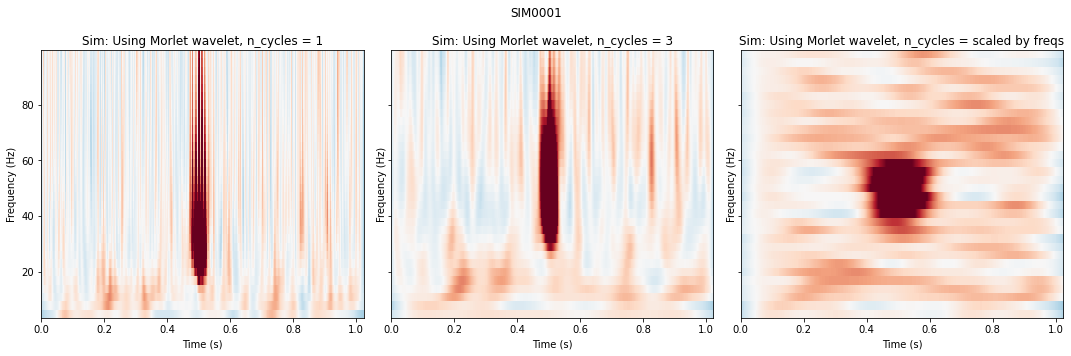

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
all_n_cycles = [1, 3, freqs / 2.]
for n_cycles, ax in zip(all_n_cycles, axs):
    power = tfr_morlet(epochs, freqs=freqs,
                       n_cycles=n_cycles, return_itc=False)
    power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
               axes=ax, show=False, colorbar=False)
    n_cycles = 'scaled by freqs' if not isinstance(n_cycles, int) else n_cycles
    ax.set_title('Sim: Using Morlet wavelet, n_cycles = %s' % n_cycles)
plt.tight_layout()

## Calculating a TFR without averaging over epochs

It is also possible to calculate a TFR without averaging across trials.
We can do this by using ``average=False``. In this case, an instance of
:class:`mne.time_frequency.EpochsTFR` is returned.



Not setting metadata
<class 'mne.time_frequency.tfr.EpochsTFR'>
Applying baseline correction (mode: mean)


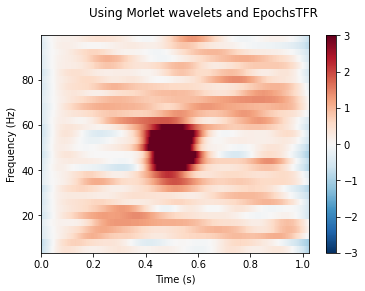

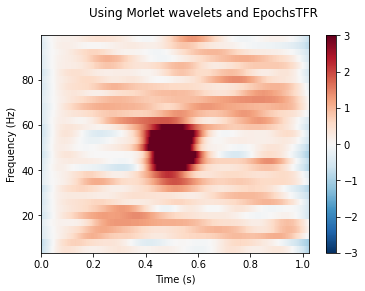

In [10]:
n_cycles = freqs / 2.
power = tfr_morlet(epochs, freqs=freqs,
                   n_cycles=n_cycles, return_itc=False, average=False)
print(type(power))
avgpower = power.average()
avgpower.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
              title='Using Morlet wavelets and EpochsTFR', show=False)

## Operating on arrays

MNE also has versions of the functions above which operate on numpy arrays
instead of MNE objects. They expect inputs of the shape
``(n_epochs, n_channels, n_times)``. They will also return a numpy array
of shape ``(n_epochs, n_channels, n_freqs, n_times)``.



Applying baseline correction (mode: mean)


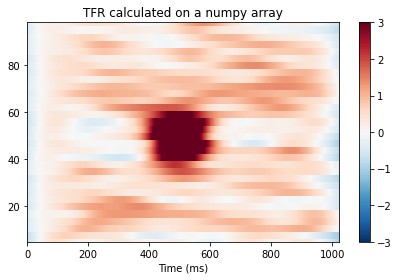

In [11]:
power = tfr_array_morlet(epochs.get_data(), sfreq=epochs.info['sfreq'],
                         freqs=freqs, n_cycles=n_cycles,
                         output='avg_power')
# Baseline the output
rescale(power, epochs.times, (0., 0.1), mode='mean', copy=False)
fig, ax = plt.subplots()
x, y = centers_to_edges(epochs.times * 1000, freqs)
mesh = ax.pcolormesh(x, y, power[0], cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_title('TFR calculated on a numpy array')
ax.set(ylim=freqs[[0, -1]], xlabel='Time (ms)')
fig.colorbar(mesh)
plt.tight_layout()

plt.show()